In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import wf_psf as wf

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_psf_field as tf_psf_field

In [2]:
# Plot style & colormap

import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


plot_style = {
    'mpl_toolkits.legacy_colorbar': False,
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

# Load model

In [3]:
# Model arguments
# (replaces the cli parameters)

args_4096 = {
    'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/4096_3x/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_005_wfeRes_4096.npy',
    'test_dataset_file': 'test_Euclid_res_id_005_wfeRes_4096.npy',
    'weights_paths': './../wf-outputs/chkp/4096_wfeRes/chkp_callback_poly_full_poly_wfeRes_4096_cycle2',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,

    'gt_pupil_diameter':4096,
}

args_256 = {
    'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/4096_3x/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_005_wfeRes_256.npy',
    'test_dataset_file': 'test_Euclid_res_id_005_wfeRes_256.npy',
    'weights_paths': './../wf-outputs/chkp/256_wfeRes/chkp_callback_poly_full_poly_wfeRes_256_cycle2',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,

    'gt_pupil_diameter':256,
}

n_bins_lda = 20

saving_dir = './../figures/'

In [4]:
## Load train datasets to get the C_poly coefficients
train_dataset_4096 = np.load(args_4096['dataset_folder'] + args_4096['train_dataset_file'], allow_pickle=True)[()]
train_C_poly = train_dataset_4096['C_poly']

# Load test datasets
test_dataset_4096 = np.load(args_4096['dataset_folder'] + args_4096['test_dataset_file'], allow_pickle=True)[()]
test_stars_4096 = test_dataset_4096['stars']
test_pos = test_dataset_4096['positions']
test_SEDs = test_dataset_4096['SEDs']
test_zernike_coef = test_dataset_4096['zernike_coef']
test_super_stars_4096 = test_dataset_4096['super_res_stars']

test_dataset_256 = np.load(args_256['dataset_folder'] + args_256['test_dataset_file'], allow_pickle=True)[()]
test_stars_256 = test_dataset_256['stars']
test_super_stars_256 = test_dataset_256['super_res_stars']

In [5]:
## Prepare zernikes and obscurations for both models (256x256 WFE_resolution)
# Generate Zernike maps for both models
zernikes_pred = wf_utils.zernike_generator(n_zernikes=args_256['n_zernikes'], wfe_dim=args_256['pupil_diameter'])
# Now as cubes
np_zernike_cube_pred = np.zeros((len(zernikes_pred), zernikes_pred[0].shape[0], zernikes_pred[0].shape[1]))
for it in range(len(zernikes_pred)):
    np_zernike_cube_pred[it,:,:] = zernikes_pred[it]
np_zernike_cube_pred[np.isnan(np_zernike_cube_pred)] = 0
tf_zernike_cube_pred = tf.convert_to_tensor(np_zernike_cube_pred, dtype=tf.float32)

# Get obscurations for both models
simPSF_np_pred = SimPSFToolkit(
    zernikes_pred,
    max_order=args_256['n_zernikes'],
    pupil_diameter=args_256['pupil_diameter'],
    output_dim=args_256['output_dim'],
    oversampling_rate=args_256['oversampling_rate'],
    output_Q=args_256['output_q']
)

# Obscurations
obscurations_256 = np.copy(simPSF_np_pred.obscurations)
tf_obscurations_256 = tf.convert_to_tensor(obscurations_256, dtype=tf.complex64)



In [6]:
# Initialize the models
tf_semiparam_field_256 = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube_pred,
    obscurations=tf_obscurations_256,
    batch_size=args_256['batch_size'],
    output_Q=args_256['output_q'],
    d_max_nonparam=args_256['d_max_nonparam'],
    l2_param=args_256['l2_param'],
    output_dim=args_256['output_dim'],
    n_zernikes=args_256['n_zernikes'],
    d_max=args_256['d_max'],
    x_lims=args_256['x_lims'],
    y_lims=args_256['y_lims']
)

tf_semiparam_field_4096 = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube_pred,
    obscurations=tf_obscurations_256,
    batch_size=args_4096['batch_size'],
    output_Q=args_4096['output_q'],
    d_max_nonparam=args_4096['d_max_nonparam'],
    l2_param=args_4096['l2_param'],
    output_dim=args_4096['output_dim'],
    n_zernikes=args_4096['n_zernikes'],
    d_max=args_4096['d_max'],
    x_lims=args_4096['x_lims'],
    y_lims=args_4096['y_lims']
)

In [7]:
# Load the model's weights
tf_semiparam_field_256.load_weights(args_256['weights_paths'])
tf_semiparam_field_4096.load_weights(args_4096['weights_paths'])

# Get the data-driven features
DD_features_256 = tf_semiparam_field_256.tf_np_poly_opd.S_mat.numpy()
DD_features_4096 = tf_semiparam_field_4096.tf_np_poly_opd.S_mat.numpy()

# Learned data-driven features

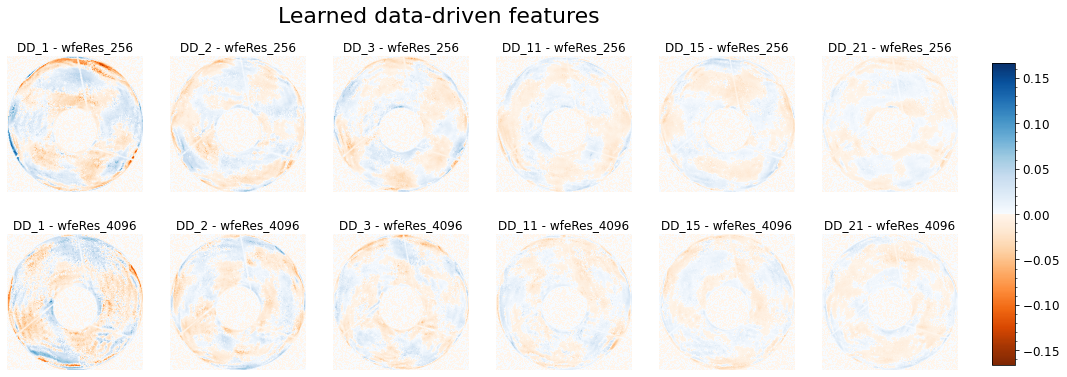

In [8]:
id_maps = [0, 1, 2, 10, 14, 20]

vmax = np.max(abs(DD_features_256[id_maps,:,:]))

fig = plt.figure(figsize=(16, 6))
fig.suptitle('Learned data-driven features', fontsize=22)

for idx, map_id in enumerate(id_maps):
    plt.subplot(2,6,1+idx)
    im = plt.imshow(DD_features_256[map_id,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.axis('off')
    plt.title('DD_{idx} - wfeRes_256'.format(idx=map_id+1))
    plt.subplot(2,6,2+len(id_maps)-1+idx)
    plt.imshow(DD_features_4096[map_id,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.axis('off')
    plt.title('DD_{idx} - wfeRes_4096'.format(idx=map_id+1))

# Colorbar
fig.subplots_adjust(right=0.95)
cbar = fig.add_axes([0.98, 0.15, 0.02, 0.7])
fig.colorbar( im , cax=cbar)
cbar.minorticks_on()

#plt.savefig(saving_dir+'DD_features.pdf')
plt.show()

# Prepare the Ground Truth (GT) model

In [9]:
## Prepare ground truth model
# Generate Zernike maps in ground truth WFE resolutions
zernikes_4096_gt = wf_utils.zernike_generator(n_zernikes=args_4096['gt_n_zernikes'], wfe_dim=args_4096['gt_pupil_diameter'])
# Now as cubes
np_zernike_cube_4096_gt = np.zeros((len(zernikes_4096_gt), zernikes_4096_gt[0].shape[0], zernikes_4096_gt[0].shape[1]))
for it in range(len(zernikes_4096_gt)):
    np_zernike_cube_4096_gt[it,:,:] = zernikes_4096_gt[it]
np_zernike_cube_4096_gt[np.isnan(np_zernike_cube_4096_gt)] = 0
tf_zernike_cube_4096_gt = tf.convert_to_tensor(np_zernike_cube_4096_gt, dtype=tf.float32)

zernikes_256_gt = wf_utils.zernike_generator(n_zernikes=args_256['gt_n_zernikes'], wfe_dim=args_256['gt_pupil_diameter'])
# Now as cubes
np_zernike_cube_256_gt = np.zeros((len(zernikes_256_gt), zernikes_256_gt[0].shape[0], zernikes_256_gt[0].shape[1]))
for it in range(len(zernikes_256_gt)):
    np_zernike_cube_256_gt[it,:,:] = zernikes_256_gt[it]
np_zernike_cube_256_gt[np.isnan(np_zernike_cube_256_gt)] = 0
tf_zernike_cube_256_gt = tf.convert_to_tensor(np_zernike_cube_256_gt, dtype=tf.float32)

# Get obscurations at high WFE resolution
simPSF_np_4096 = SimPSFToolkit(
    zernikes_4096_gt,
    max_order=args_4096['n_zernikes'],
    pupil_diameter=args_4096['gt_pupil_diameter'],
    output_dim=args_4096['output_dim'],
    oversampling_rate=args_4096['oversampling_rate'],
    output_Q=args_4096['output_q']
)

obscurations_4096 = np.copy(simPSF_np_4096.obscurations)
tf_obscurations_4096 = tf.convert_to_tensor(obscurations_4096, dtype=tf.complex64)


In [10]:

# Initialize the models
GT_tf_semiparam_field_256 = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube_256_gt,
    obscurations=tf_obscurations_256,
    batch_size=args_256['batch_size'],
    output_Q=args_256['output_q'],
    d_max_nonparam=args_256['d_max_nonparam'],
    output_dim=args_256['output_dim'],
    n_zernikes=args_256['gt_n_zernikes'],
    d_max=args_256['d_max'],
    x_lims=args_256['x_lims'],
    y_lims=args_256['y_lims']
)

GT_tf_semiparam_field_4096 = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube_4096_gt,
    obscurations=tf_obscurations_4096,
    batch_size=args_4096['batch_size'],
    output_Q=args_4096['output_q'],
    d_max_nonparam=args_4096['d_max_nonparam'],
    output_dim=args_4096['output_dim'],
    n_zernikes=args_4096['gt_n_zernikes'],
    d_max=args_4096['d_max'],
    x_lims=args_4096['x_lims'],
    y_lims=args_4096['y_lims']
)

# For the Ground truth model load C_poly coefficients
GT_tf_semiparam_field_256.tf_poly_Z_field.assign_coeff_matrix(train_C_poly)
_ = GT_tf_semiparam_field_256.tf_np_poly_opd.alpha_mat.assign(
    np.zeros_like(GT_tf_semiparam_field_256.tf_np_poly_opd.alpha_mat)
)

GT_tf_semiparam_field_4096.tf_poly_Z_field.assign_coeff_matrix(train_C_poly)
_ = GT_tf_semiparam_field_4096.tf_np_poly_opd.alpha_mat.assign(
    np.zeros_like(GT_tf_semiparam_field_4096.tf_np_poly_opd.alpha_mat)
)


# PSF Recovery

In [11]:
n_stars = 1

tf_SEDs = test_SEDs[0:n_stars,:,:]
tf_test_pos = tf.convert_to_tensor(test_pos[0:n_stars,:], dtype=tf.float32)
batch_size = args_256['batch_size']


# Generate SED data lists for prediction
packed_SED_data_pred = [wf.utils.generate_packed_elems(_sed, simPSF_np_pred, n_bins=n_bins_lda)
                        for _sed in tf_SEDs]
tf_packed_SED_data_pred = tf.convert_to_tensor(packed_SED_data_pred, dtype=tf.float32)
tf_packed_SED_data_pred = tf.transpose(tf_packed_SED_data_pred, perm=[0, 2, 1])
pred_inputs_pred = [tf_test_pos , tf_packed_SED_data_pred]

# Model predictions
preds_256 = tf_semiparam_field_256.predict(x=pred_inputs_pred, batch_size=batch_size)
preds_4096 = tf_semiparam_field_4096.predict(x=pred_inputs_pred, batch_size=batch_size)

In [14]:
# Select star from 0 to n_stars to use for following plots & tests
test_star = 0

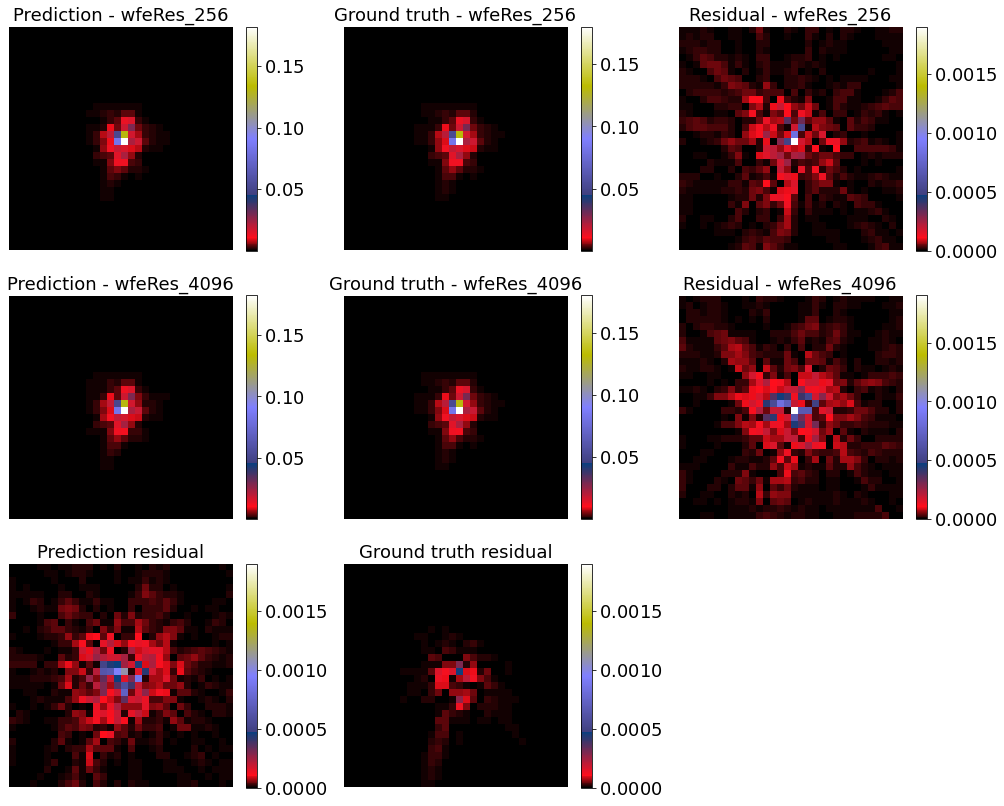

In [24]:
vmax = np.max(np.abs(test_stars_256[test_star,:,:] - preds_256[test_star,:,:]))
font_size = 18

fig, ax = plt.subplots(3, 3, figsize=(17,14))

#fig.suptitle('PSFs comparison @ Euclid-Res', fontsize=22)

im = ax[0][0].imshow(preds_256[test_star,:,:], cmap='gist_stern')
ax[0][0].set_title('Prediction - wfeRes_256', fontsize=font_size)
cbar=plt.colorbar(im, ax=ax[0][0])
cbar.ax.tick_params(labelsize=font_size)
ax[0][0].axis('off')

im = ax[0][1].imshow(test_stars_256[test_star,:,:], cmap='gist_stern')
ax[0][1].set_title('Ground truth - wfeRes_256', fontsize=font_size)
cbar=plt.colorbar(im, ax=ax[0][1])
cbar.ax.tick_params(labelsize=font_size)
ax[0][1].axis('off')

im = ax[0][2].imshow(np.abs(test_stars_256[test_star,:,:] - preds_256[test_star,:,:]), cmap='gist_stern', vmax=vmax, vmin=0)
ax[0][2].set_title('Residual - wfeRes_256', fontsize=font_size)
cbar=plt.colorbar(im, ax=ax[0][2])
cbar.ax.tick_params(labelsize=font_size)
ax[0][2].axis('off')

im = ax[1][0].imshow(preds_4096[test_star,:,:], cmap='gist_stern')
ax[1][0].set_title('Prediction - wfeRes_4096', fontsize=font_size)
cbar=plt.colorbar(im, ax=ax[1][0])
cbar.ax.tick_params(labelsize=font_size)
ax[1][0].axis('off')

im = ax[1][1].imshow(test_stars_4096[test_star,:,:], cmap='gist_stern')
ax[1][1].set_title('Ground truth - wfeRes_4096', fontsize=font_size)
cbar=plt.colorbar(im, ax=ax[1][1])
cbar.ax.tick_params(labelsize=font_size)
ax[1][1].axis('off')

im = ax[1][2].imshow(np.abs(test_stars_4096[test_star,:,:] - preds_4096[test_star,:,:]), cmap='gist_stern', vmax=vmax, vmin=0)
ax[1][2].set_title('Residual - wfeRes_4096', fontsize=font_size)
cbar=plt.colorbar(im, ax=ax[1][2])
cbar.ax.tick_params(labelsize=font_size)
ax[1][2].axis('off')

im = ax[2][0].imshow(np.abs(preds_256[test_star,:,:] - preds_4096[test_star,:,:]), cmap='gist_stern', vmax=vmax, vmin=0)
ax[2][0].set_title('Prediction residual', fontsize=font_size)
cbar=plt.colorbar(im, ax=ax[2][0])
cbar.ax.tick_params(labelsize=font_size)
ax[2][0].axis('off')

im = ax[2][1].imshow(np.abs(test_stars_256[test_star,:,:] - test_stars_4096[test_star,:,:]), cmap='gist_stern', vmax=vmax, vmin=0)
ax[2][1].set_title('Ground truth residual', fontsize=font_size)
cbar=plt.colorbar(im, ax=ax[2][1])
cbar.ax.tick_params(labelsize=font_size)
ax[2][1].axis('off')

ax[2][2].axis('off')

plt.savefig(saving_dir+'PSF_comparison_d5.pdf')
plt.show()

## PSF comparison @ 3xEuclid resolution

In [14]:
output_Q=1
output_dim=64


# Save original output_Q and output_dim
original_out_Q = tf_semiparam_field_256.output_Q
original_out_dim = tf_semiparam_field_256.output_dim
GT_original_out_Q = GT_tf_semiparam_field_256.output_Q
GT_original_out_dim = GT_tf_semiparam_field_256.output_dim

# Set the required output_Q and output_dim parameters in the models
tf_semiparam_field_256.set_output_Q(output_Q=output_Q, output_dim=output_dim)
GT_tf_semiparam_field_256.set_output_Q(output_Q=output_Q, output_dim=output_dim)

tf_semiparam_field_4096.set_output_Q(output_Q=output_Q, output_dim=output_dim)
GT_tf_semiparam_field_4096.set_output_Q(output_Q=output_Q, output_dim=output_dim)

# Need to compile the models again
tf_semiparam_field_256_3x = wf.tf_psf_field.build_PSF_model(tf_semiparam_field_256)
GT_tf_semiparam_field_256_3x = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field_256)

tf_semiparam_field_4096_3x = wf.tf_psf_field.build_PSF_model(tf_semiparam_field_4096)
GT_tf_semiparam_field_4096_3x = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field_4096)

# Predict super resolved PSF for each model 
predictions_256 = tf_semiparam_field_256_3x.predict(x=pred_inputs_pred, batch_size=batch_size)
predictions_4096 = tf_semiparam_field_4096_3x.predict(x=pred_inputs_pred, batch_size=batch_size)


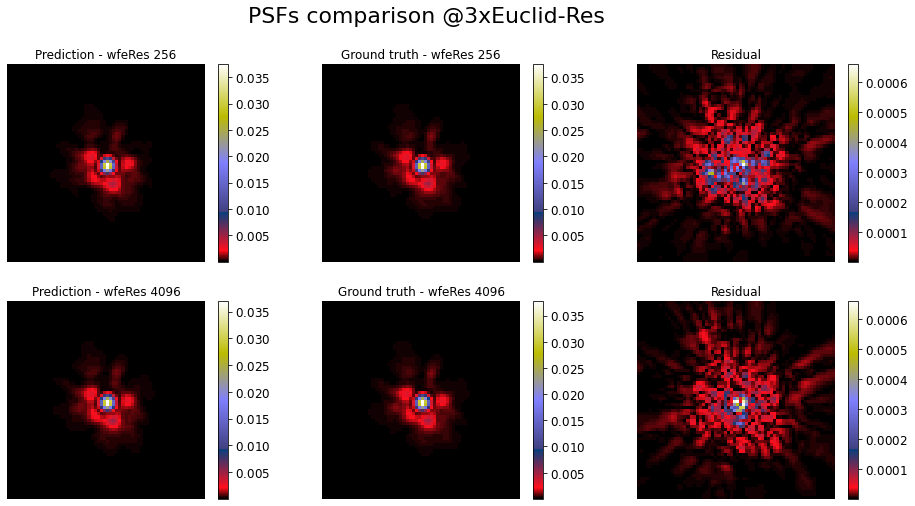

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(16,8))
fig.suptitle('PSFs comparison @3xEuclid-Res', fontsize=22)

im = ax[0][0].imshow(predictions_256[test_star,:,:], cmap='gist_stern')
ax[0][0].set_title('Prediction - wfeRes 256')
plt.colorbar(im, ax=ax[0][0])

im = ax[0][1].imshow(test_super_stars_256[test_star,:,:], cmap='gist_stern')
ax[0][1].set_title('Ground truth - wfeRes 256')
plt.colorbar(im, ax=ax[0][1])

vmax = np.max(np.abs(test_super_stars_256[test_star,:,:] - predictions_256[test_star,:,:]))

im = ax[0][2].imshow(np.abs(test_super_stars_256[test_star,:,:] - predictions_256[test_star,:,:]), cmap='gist_stern',vmax=vmax)
ax[0][2].set_title('Residual')
plt.colorbar(im, ax=ax[0][2])

im = ax[1][0].imshow(predictions_4096[test_star,:,:], cmap='gist_stern')
ax[1][0].set_title('Prediction - wfeRes 4096')
plt.colorbar(im, ax=ax[1][0])

im = ax[1][1].imshow(test_super_stars_4096[test_star,:,:], cmap='gist_stern')
ax[1][1].set_title('Ground truth - wfeRes 4096')
plt.colorbar(im, ax=ax[1][1])

im = ax[1][2].imshow(np.abs(test_super_stars_4096[test_star,:,:] - predictions_4096[test_star,:,:]), cmap='gist_stern',vmax=vmax)
ax[1][2].set_title('Residual')
plt.colorbar(im, ax=ax[1][2])

for axis in ax.ravel():
    axis.set_xticks([])
    axis.set_yticks([])
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)

#plt.savefig(saving_dir+'PSF_comparison_3x.pdf')
plt.show()


# WFE reconstruction

In [16]:
def PI_zernikes(tf_z1,tf_z2,norm_factor=None):
    """ Compute internal product between zernikes and OPDs

    Defined such that Zernikes are orthonormal to each other    
    """
    if norm_factor is None:
        norm_factor = 1
    return sum(sum(tf.math.multiply(tf_z1,tf_z2) )).numpy()/(norm_factor)

def OPD_remove_zero(opd):
    """ Substract the zero-th order zernike from the opd, i.d. remove average value from the circular aperture.
    """
    z_0 = PI_zernikes(opd,np_zernike_cube_pred[0,:,:], n_pix_zernike)
    return opd - z_0 * np_zernike_cube_pred[0,:,:]

n_pix_zernike = PI_zernikes(tf_zernike_cube_256_gt[0,:,:],tf_zernike_cube_256_gt[0,:,:])

In [17]:
batch_pos = tf_test_pos

# We calculate a batch of OPDs
opd_batch_4096 = tf_semiparam_field_4096.predict_opd(batch_pos)
opd_batch_256 = tf_semiparam_field_256.predict_opd(batch_pos)

# Ground truth OPDs
gt_opd_4096 = sum([np_zernike_cube_4096_gt[k,:,:]*test_zernike_coef[test_star,k,0] for k in range(args_256['gt_n_zernikes'])])
gt_opd_256 = sum([np_zernike_cube_256_gt[k,:,:]*test_zernike_coef[test_star,k,0] for k in range(args_256['gt_n_zernikes'])])

In [18]:
opd_pred_256_np = np.array(opd_batch_256[test_star,:,:])
pred_opd_256 = OPD_remove_zero(opd_pred_256_np)

opd_pred_4096_np = np.array(opd_batch_4096[test_star,:,:])
pred_opd_4096 = OPD_remove_zero(opd_pred_4096_np)

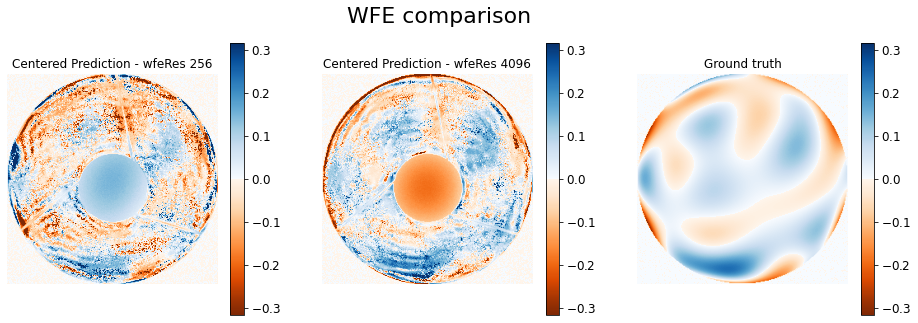

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

fig.suptitle('WFE comparison', fontsize=22)

vmax = np.max(np.abs(gt_opd_256))
im = ax[0].imshow(pred_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0].set_title('Centered Prediction - wfeRes 256')
plt.colorbar(im, ax=ax[0])

im = ax[1].imshow(pred_opd_4096, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1].set_title('Centered Prediction - wfeRes 4096')
plt.colorbar(im, ax=ax[1])

im = ax[2].imshow(gt_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[2].set_title('Ground truth')
plt.colorbar(im, ax=ax[2])

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)

plt.savefig(saving_dir+'WFE_comparison_d5.pdf')
plt.show()

## Energy distribution over zernikes

In [20]:
# Get zernike coefficients for the parametric part
zernike_coefs_256 = tf_semiparam_field_256.tf_poly_Z_field(batch_pos)
# Construct the parametric part of the OPD
param_opd_batch_256 = tf_semiparam_field_256.tf_zernike_OPD(zernike_coefs_256)
# Remove the mean from the 'test_star' OPD
param_opd_256 = OPD_remove_zero(np.array(param_opd_batch_256[test_star,:,:]))
# Get the non-parametric parte of the OPD
non_param_opd_batch_256 = tf_semiparam_field_256.tf_np_poly_opd(batch_pos)
# Remove the mean from the 'test_star' OPD
non_param_opd_256 = OPD_remove_zero(np.array(non_param_opd_batch_256[test_star,:,:]))

# Repeat for the other dataset
zernike_coefs_4096 = tf_semiparam_field_4096.tf_poly_Z_field(batch_pos)
param_opd_batch_4096 = tf_semiparam_field_4096.tf_zernike_OPD(zernike_coefs_4096)
param_opd_4096 = OPD_remove_zero(np.array(param_opd_batch_4096[test_star,:,:]))
non_param_opd_batch_4096 = tf_semiparam_field_4096.tf_np_poly_opd(batch_pos)
non_param_opd_4096 = OPD_remove_zero(np.array(non_param_opd_batch_4096[test_star,:,:]))

In [21]:
zernike_param_energy_256 = PI_zernikes(param_opd_256,param_opd_256,n_pix_zernike)
zernike_non_param_energy_256 = PI_zernikes(non_param_opd_256,non_param_opd_256,n_pix_zernike)

zernike_param_energy_4096 = PI_zernikes(param_opd_4096,param_opd_4096,n_pix_zernike)
zernike_non_param_energy_4096 = PI_zernikes(non_param_opd_4096,non_param_opd_4096,n_pix_zernike)

print('Energy param: ', zernike_param_energy_256)
print('Energy non param: ', zernike_non_param_energy_256)

Energy param:  0.006484250319562223
Energy non param:  0.021165877367129923


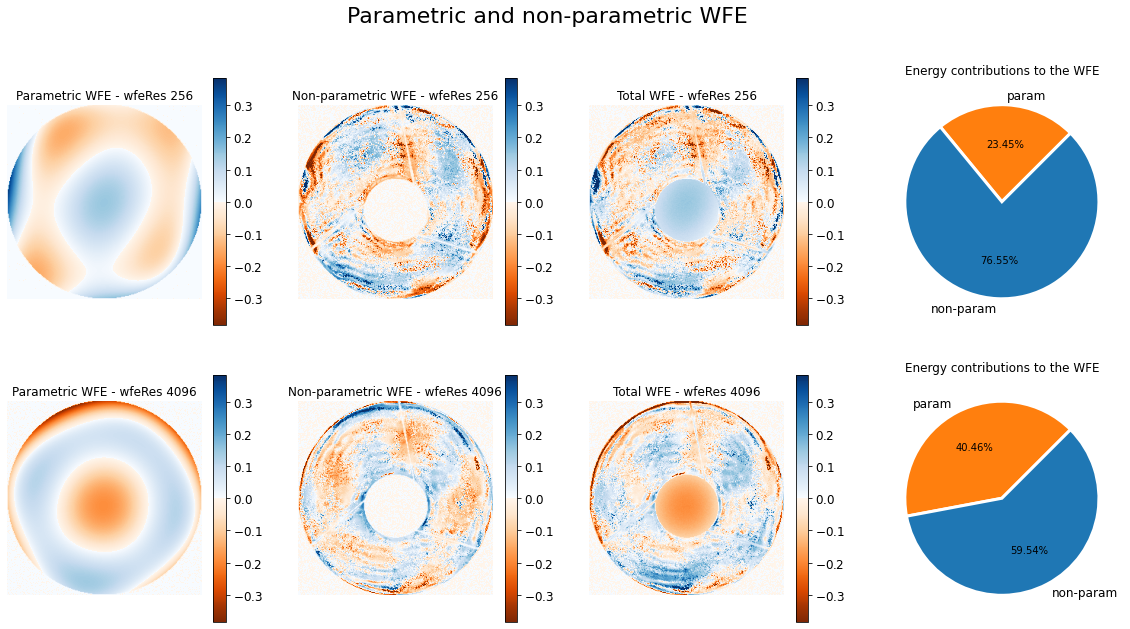

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))
fig.suptitle('Parametric and non-parametric WFE', fontsize=22)

vmax = np.max(np.abs(param_opd_4096))

im = ax[0][0].imshow(param_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][0].set_title('Parametric WFE - wfeRes 256')
plt.colorbar(im, ax=ax[0][0])
im = ax[0][1].imshow(non_param_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][1].set_title('Non-parametric WFE - wfeRes 256')
plt.colorbar(im, ax=ax[0][1])
im = ax[0][2].imshow(pred_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][2].set_title('Total WFE - wfeRes 256')
plt.colorbar(im, ax=ax[0][2])
# im = ax[0][3].imshow(gt_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
# ax[0][3].set_title('Ground truth - wfeRes 256')
# plt.colorbar(im, ax=ax[0][3])
im = ax[0][3].pie([zernike_param_energy_256, zernike_non_param_energy_256], colors=['tab:orange', 'tab:blue'],labels=['param','non-param'], autopct='%1.2f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, startangle = 45)
ax[0][3].set_title('Energy contributions to the WFE')

im = ax[1][0].imshow(param_opd_4096, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1][0].set_title('Parametric WFE - wfeRes 4096')
plt.colorbar(im, ax=ax[1][0])
im = ax[1][1].imshow(non_param_opd_4096, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1][1].set_title('Non-parametric WFE - wfeRes 4096')
plt.colorbar(im, ax=ax[1][1])
im = ax[1][2].imshow(pred_opd_4096, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1][2].set_title('Total WFE - wfeRes 4096')
plt.colorbar(im, ax=ax[1][2])
# im = ax[1][3].imshow(gt_opd_4096, cmap=newcmp, vmax=vmax, vmin=-vmax)
# ax[1][3].set_title('Ground truth - wfeRes 4096')
# plt.colorbar(im, ax=ax[1][3])
im = ax[1][3].pie([zernike_param_energy_4096, zernike_non_param_energy_4096], colors=['tab:orange', 'tab:blue'],labels=['param','non-param'], autopct='%1.2f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, startangle = 45)
ax[1][3].set_title('Energy contributions to the WFE')

for axis in ax.ravel():
    axis.set_xticks([])
    axis.set_yticks([])
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)

#plt.savefig(saving_dir+'WFE_energy_compare.pdf')

plt.show()

# Parametric vs full PSF

In [23]:
PSF_param_256 = tf_semiparam_field_256.tf_batch_poly_PSF([tf.expand_dims(tf.convert_to_tensor(param_opd_256), axis=0), tf_packed_SED_data_pred[test_star:test_star+1,:,:]])[0,:,:]
PSF_non_param_256 = tf_semiparam_field_256.tf_batch_poly_PSF([tf.expand_dims(tf.convert_to_tensor(non_param_opd_256), axis=0), tf_packed_SED_data_pred[test_star:test_star+1,:,:]])[0,:,:]
PSF_param_4096 = tf_semiparam_field_256.tf_batch_poly_PSF([tf.expand_dims(tf.convert_to_tensor(param_opd_4096), axis=0), tf_packed_SED_data_pred[test_star:test_star+1,:,:]])[0,:,:]
PSF_non_param_4096 = tf_semiparam_field_256.tf_batch_poly_PSF([tf.expand_dims(tf.convert_to_tensor(non_param_opd_4096), axis=0), tf_packed_SED_data_pred[test_star:test_star+1,:,:]])[0,:,:]

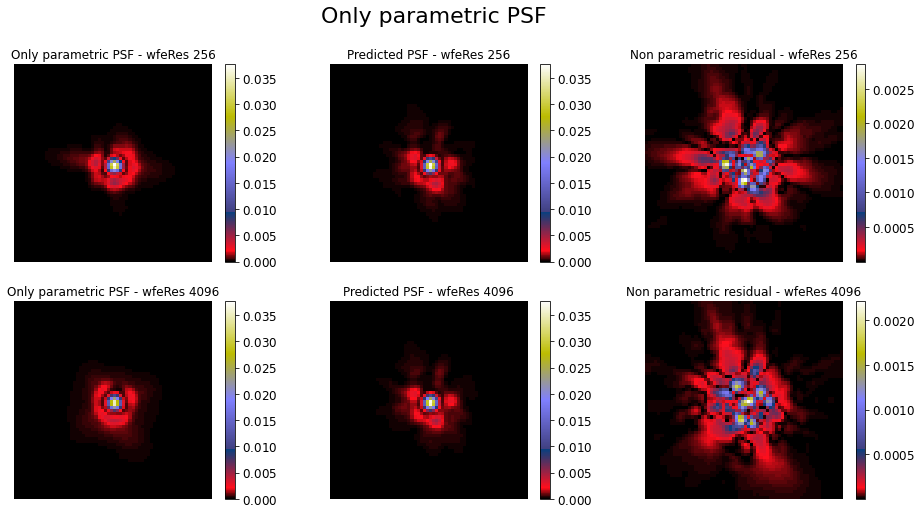

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(16,8))

fig.suptitle('Only parametric PSF', fontsize=22)

vmax = np.max(np.abs(PSF_param_256))

im = ax[0][0].imshow(PSF_param_256, cmap='gist_stern', vmax=vmax, vmin=0)
ax[0][0].set_title('Only parametric PSF - wfeRes 256')
plt.colorbar(im, ax=ax[0][0])

im = ax[0][1].imshow(predictions_256[test_star,:,:], cmap='gist_stern', vmax=vmax, vmin=0)
ax[0][1].set_title('Predicted PSF - wfeRes 256')
plt.colorbar(im, ax=ax[0][1])

im = ax[0][2].imshow(np.abs(predictions_256[test_star,:,:]-PSF_param_256), cmap='gist_stern')
ax[0][2].set_title('Non parametric residual - wfeRes 256')
plt.colorbar(im, ax=ax[0][2])

im = ax[1][0].imshow(PSF_param_4096, cmap='gist_stern', vmax=vmax, vmin=0)
ax[1][0].set_title('Only parametric PSF - wfeRes 4096')
plt.colorbar(im, ax=ax[1][0])

im = ax[1][1].imshow(predictions_4096[test_star,:,:], cmap='gist_stern', vmax=vmax, vmin=0)
ax[1][1].set_title('Predicted PSF - wfeRes 4096')
plt.colorbar(im, ax=ax[1][1])

im = ax[1][2].imshow(np.abs(predictions_4096[test_star,:,:]-PSF_param_4096), cmap='gist_stern')
ax[1][2].set_title('Non parametric residual - wfeRes 4096')
plt.colorbar(im, ax=ax[1][2])

for axis in ax.ravel():
    axis.set_xticks([])
    axis.set_yticks([])
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)

#plt.savefig(saving_dir+'parametric_PSF.pdf')

plt.show()

In [25]:
abs_RMS_residual = np.sqrt(np.mean((predictions_256[test_star,:,:] - PSF_param_256)**2))
abs_RMS_predicted = np.sqrt(np.mean((predictions_256[test_star,:,:])**2))
relative_residual = 100. * ( abs_RMS_residual/ abs_RMS_predicted)
print('The relative RMS of the PSF non parametric residual against the predicted PSF is: {:.2f}%'.format(relative_residual))

The relative RMS of the PSF non parametric residual against the predicted PSF is: 15.17%


In [26]:
abs_RMS_residual = np.sqrt(np.mean((predictions_4096[test_star,:,:] - PSF_param_4096)**2))
abs_RMS_predicted = np.sqrt(np.mean((predictions_4096[test_star,:,:])**2))
relative_residual = 100. * ( abs_RMS_residual/ abs_RMS_predicted)
print('The relative RMS of the PSF non parametric residual against the predicted PSF is: {:.2f}%'.format(relative_residual))

The relative RMS of the PSF non parametric residual against the predicted PSF is: 11.72%


# Zernike energy distribution

In [27]:
# Project predicted OPD into gt_n_zernikes
z_coefs_256_pred = [PI_zernikes(pred_opd_256, np_zernike_cube_256_gt[k,:,:], n_pix_zernike) for k in range(args_256['gt_n_zernikes'])]
# Compute residual OPD after projection and its energy
residual_opd_256 = pred_opd_256 - sum([np_zernike_cube_256_gt[k,:,:]*z_coefs_256_pred[k] for k in range(args_256['gt_n_zernikes'])])
residual_opd_energy_sqrt = np.sqrt(PI_zernikes(residual_opd_256,residual_opd_256,n_pix_zernike))
z_coefs_256_residual = np.append(np.zeros(args_256['gt_n_zernikes']),residual_opd_energy_sqrt)
# Load ground truth coefficients
z_coefs_256_gt = test_zernike_coef[test_star,:,0]
# Non parametric OPD projection over zernikes
z_coefs_256_project_non_param = [PI_zernikes(non_param_opd_256, np_zernike_cube_256_gt[k,:,:], n_pix_zernike) for k in range(args_256['gt_n_zernikes'])]

# Repeat for the other dataset
z_coefs_4096_pred = [PI_zernikes(pred_opd_4096, np_zernike_cube_256_gt[k,:,:], n_pix_zernike) for k in range(args_4096['gt_n_zernikes'])]
residual_opd_4096 = pred_opd_4096 - sum([np_zernike_cube_256_gt[k,:,:]*z_coefs_4096_pred[k] for k in range(args_4096['gt_n_zernikes'])])
residual_opd_energy_sqrt = np.sqrt(PI_zernikes(residual_opd_4096,residual_opd_4096,n_pix_zernike))
z_coefs_4096_residual = np.append(np.zeros(args_4096['gt_n_zernikes']),residual_opd_energy_sqrt)
z_coefs_4096_gt = test_zernike_coef[test_star,:,0]
z_coefs_4096_project_non_param = [PI_zernikes(non_param_opd_4096, np_zernike_cube_256_gt[k,:,:], n_pix_zernike) for k in range(args_4096['gt_n_zernikes'])]


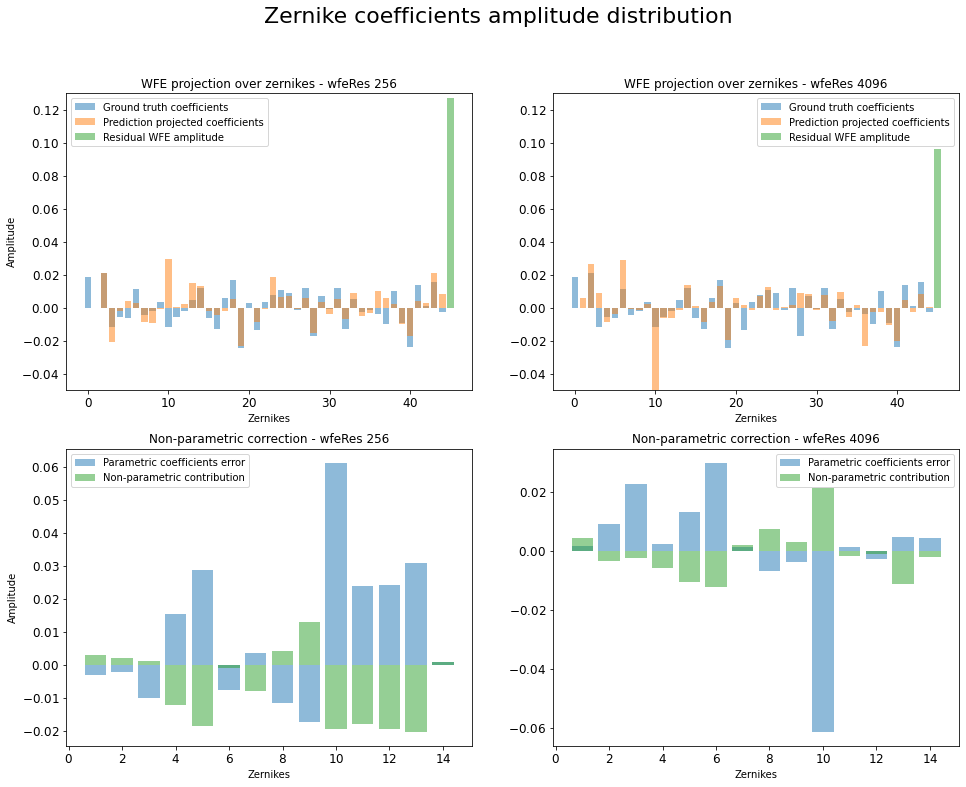

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(16,12))
fig.suptitle('Zernike coefficients amplitude distribution', fontsize=22)

ax[0][0].bar(np.array(range(args_256['gt_n_zernikes']+1)), np.append(z_coefs_256_gt,0),alpha=0.5)
ax[0][0].bar(np.array(range(args_256['gt_n_zernikes']+1)), np.append(np.array(z_coefs_256_pred),0), alpha=0.5)
ax[0][0].bar(np.array(range(args_256['gt_n_zernikes']+1)), z_coefs_256_residual, alpha=0.5)
ax[0][0].legend(['Ground truth coefficients','Prediction projected coefficients','Residual WFE amplitude'])
ax[0][0].set_title('WFE projection over zernikes - wfeRes 256')
ax[0][0].set_ylim((-0.05,0.13))
ax[0][0].set_xlabel('Zernikes')
ax[0][0].set_ylabel('Amplitude')

ax[0][1].bar(np.array(range(args_4096['gt_n_zernikes']+1)), np.append(z_coefs_4096_gt,0),alpha=0.5)
ax[0][1].bar(np.array(range(args_4096['gt_n_zernikes']+1)), np.append(np.array(z_coefs_4096_pred),0), alpha=0.5)
ax[0][1].bar(np.array(range(args_4096['gt_n_zernikes']+1)), z_coefs_4096_residual, alpha=0.5)
ax[0][1].legend(['Ground truth coefficients','Prediction projected coefficients','Residual WFE amplitude'])
ax[0][1].set_title('WFE projection over zernikes - wfeRes 4096')
ax[0][1].set_ylim((-0.05,0.13))
ax[0][1].set_xlabel('Zernikes')

ax[1][0].bar(np.array(range(args_256['n_zernikes']-1))+1, np.array(zernike_coefs_256[test_star,1:,0,0]) - np.array(z_coefs_256_gt[1:args_256['n_zernikes']]), alpha=0.5)
ax[1][0].bar(np.array(range(args_256['n_zernikes']-1))+1, np.array(z_coefs_256_project_non_param[1:args_256['n_zernikes']]), alpha=0.5, color='tab:green')
ax[1][0].legend(['Parametric coefficients error','Non-parametric contribution'])
ax[1][0].set_title('Non-parametric correction - wfeRes 256')
ax[1][0].set_xlabel('Zernikes')
ax[1][0].set_ylabel('Amplitude')

ax[1][1].bar(np.array(range(args_4096['n_zernikes']-1))+1, np.array(zernike_coefs_4096[test_star,1:,0,0]) - np.array(z_coefs_4096_gt[1:args_4096['n_zernikes']]), alpha=0.5)
ax[1][1].bar(np.array(range(args_4096['n_zernikes']-1))+1, np.array(z_coefs_4096_project_non_param[1:args_4096['n_zernikes']]), alpha=0.5, color='tab:green')
ax[1][1].legend(['Parametric coefficients error','Non-parametric contribution'])
ax[1][1].set_title('Non-parametric correction - wfeRes 4096')
ax[1][1].set_xlabel('Zernikes')

plt.savefig(saving_dir+'zernike_amplitude_distribution.pdf')
plt.show()

# Thoughts and comments on the results

- One can clearly see that the learnt OPD/WFE from the higher resolution dataset has more details and looks more similar to the ground truth. It seems that a bigger WFE permeates lots of details to the low resolution PSF, and this détails allow for a better WFE prediction.

- This means that when training with real data, the model may extract in a better way the OPD/WFE (at least the comportements well represented by the zernike modeling approach).

- The parametric part doesn't do a great job at reconstructing the low-frequency OPD and the non-parametric part has to correct theese bad predictions alongside with representing the higher order and complex behaviours.

- The only-parametric PSF for the model trained with the lower resolution dataset apears to model better the high order variations of the PSF (figure: "Parametric vs full PSF"). This may suggest that the details of the high-resolution dataset hinder the correct estimation of low-frequency variations of the OPD. 